# CNN Model for Cyberbullying Detection - Google Colab

Self-contained notebook with all code embedded. Upload your train.csv to Colab before running.

In [5]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import re
import string
import time

In [7]:
# Text preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[{}]".format(string.punctuation), "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def build_vocab(texts, max_vocab=10000):
    word_freq = {}
    for text in texts:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1

    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in sorted_words[:max_vocab-2]:
        vocab[word] = len(vocab)
    return vocab

def text_to_sequence(text, vocab, max_len=100):
    words = text.split()[:max_len]
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
    if len(sequence) < max_len:
        sequence += [vocab['<PAD>']] * (max_len - len(sequence))
    return sequence

In [8]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = text_to_sequence(self.texts[idx], self.vocab, self.max_len)
        return torch.LongTensor(text), torch.FloatTensor(self.labels[idx])

In [9]:
# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

In [10]:
# Training functions
def accuracy_multilabel(preds, y, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    correct = (preds == y).float()
    return correct.mean()

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = accuracy_multilabel(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = accuracy_multilabel(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def get_predictions(model, iterator, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            predictions = model(text)
            preds = (torch.sigmoid(predictions) > threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

def calculate_metrics(y_true, y_pred, label_names):
    results = {}
    for i, label in enumerate(label_names):
        acc = accuracy_score(y_true[:, i], y_pred[:, i])
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true[:, i], y_pred[:, i], average='binary', zero_division=0
        )
        results[label] = {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

    results['overall'] = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_recall_fscore_support(y_true, y_pred, average='micro')[0],
        'recall': precision_recall_fscore_support(y_true, y_pred, average='micro')[1],
        'f1': precision_recall_fscore_support(y_true, y_pred, average='micro')[2]
    }
    return results

In [11]:
# Load and preprocess data
df = pd.read_csv("train.csv")
print(f"Total samples: {len(df)}")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(f"\nLabel distribution:")
print(df[label_cols].sum())

Total samples: 159571

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [12]:
# Preprocess text
df["clean_text"] = df["comment_text"].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"].values, df[label_cols].values,
    test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 127656, Test: 31915


In [13]:
# Build vocabulary
vocab = build_vocab(X_train, max_vocab=10000)
print(f"Vocab size: {len(vocab)}")

Vocab size: 10000


In [14]:
# Create datasets
MAX_LEN = 100
BATCH_SIZE = 64

train_dataset = TextDataset(X_train, y_train, vocab, max_len=MAX_LEN)
test_dataset = TextDataset(X_test, y_test, vocab, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = SimpleCNN(
    vocab_size=len(vocab),
    embedding_dim=100,
    n_filters=100,
    filter_sizes=[3, 4, 5],
    output_dim=len(label_cols),
    dropout=0.5
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Device: cuda
Model parameters: 1122106


In [16]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

n_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

start_time = time.time()

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.3f} Acc: {train_acc:.3f} | Test Loss: {test_loss:.3f} Acc: {test_acc:.3f}')

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f}s ({train_time/60:.2f} min)")

Epoch 01 | Train Loss: 0.086 Acc: 0.974 | Test Loss: 0.061 Acc: 0.980
Epoch 02 | Train Loss: 0.061 Acc: 0.980 | Test Loss: 0.055 Acc: 0.981
Epoch 03 | Train Loss: 0.055 Acc: 0.981 | Test Loss: 0.058 Acc: 0.980
Epoch 04 | Train Loss: 0.051 Acc: 0.982 | Test Loss: 0.055 Acc: 0.981
Epoch 05 | Train Loss: 0.048 Acc: 0.983 | Test Loss: 0.058 Acc: 0.981
Epoch 06 | Train Loss: 0.045 Acc: 0.984 | Test Loss: 0.055 Acc: 0.982
Epoch 07 | Train Loss: 0.043 Acc: 0.985 | Test Loss: 0.059 Acc: 0.981
Epoch 08 | Train Loss: 0.041 Acc: 0.986 | Test Loss: 0.061 Acc: 0.982
Epoch 09 | Train Loss: 0.038 Acc: 0.986 | Test Loss: 0.061 Acc: 0.982
Epoch 10 | Train Loss: 0.036 Acc: 0.987 | Test Loss: 0.066 Acc: 0.981

Training time: 881.29s (14.69 min)


In [17]:
# Evaluate
y_pred, y_true = get_predictions(model, test_loader, device)
metrics = calculate_metrics(y_true, y_pred, label_cols)

print("Overall Results:")
for k, v in metrics['overall'].items():
    print(f"{k}: {v:.4f}")

print("\nPer-label F1 scores:")
for label in label_cols:
    print(f"{label}: {metrics[label]['f1']:.4f}")

Overall Results:
accuracy: 0.9172
precision: 0.8211
recall: 0.6210
f1: 0.7072

Per-label F1 scores:
toxic: 0.7647
severe_toxic: 0.3721
obscene: 0.7775
threat: 0.3077
insult: 0.6491
identity_hate: 0.3797


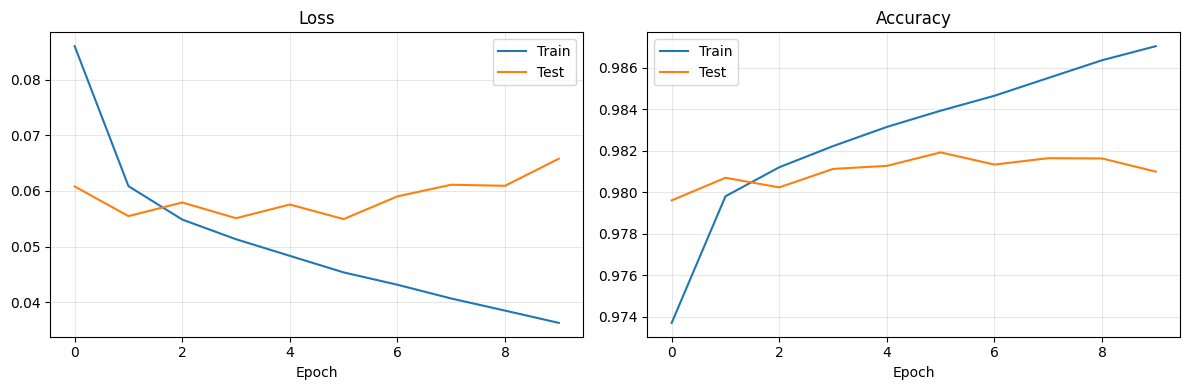

In [18]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(train_accs, label='Train')
axes[1].plot(test_accs, label='Test')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Download trained model
torch.save(model.state_dict(), 'cnn_model.pt')
files.download('cnn_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>